In [14]:
import sys
sys.path.append("../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
from tqdm import tqdm
%matplotlib inline

plt.style.use(["science","bright"])

## Functions

In [157]:
def capacitance(radius):
    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*radius
    return cap

In [2]:
N_p                 = 7
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],[0,(N_p-1)//2,0],
                          [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
}

def run_magic_cable(time_steps, voltages, topology_parameter, radius=1e6, eq_steps=0):

    np_info2 = {
        'np_index'      : [(topology_parameter["Nx"]**2-1)-topology_parameter["Nx"]//2], 
        'mean_radius'   : radius,
        'std_radius'    : 0.0
    }

    target_electrode    = len(topology_parameter["e_pos"])-1
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, np_info2=np_info2)
    sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, stat_size=10, save=False, eq_steps=eq_steps)
    results             = sim_class.return_output_values()

    return results

## Sinusoidal Input

In [164]:
# Voltage Paramter
N_voltages              = 300
amplitudes              = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
frequencies             = [1e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
time_step               = 1e-7
time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                             amplitudes=amplitudes, frequencies=frequencies, time_step=time_step)

In [10]:
radius_vals = [10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840]
results     = []
for radius in tqdm(radius_vals):
    val     = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results.append(val)

100%|██████████| 15/15 [03:20<00:00, 13.38s/it]


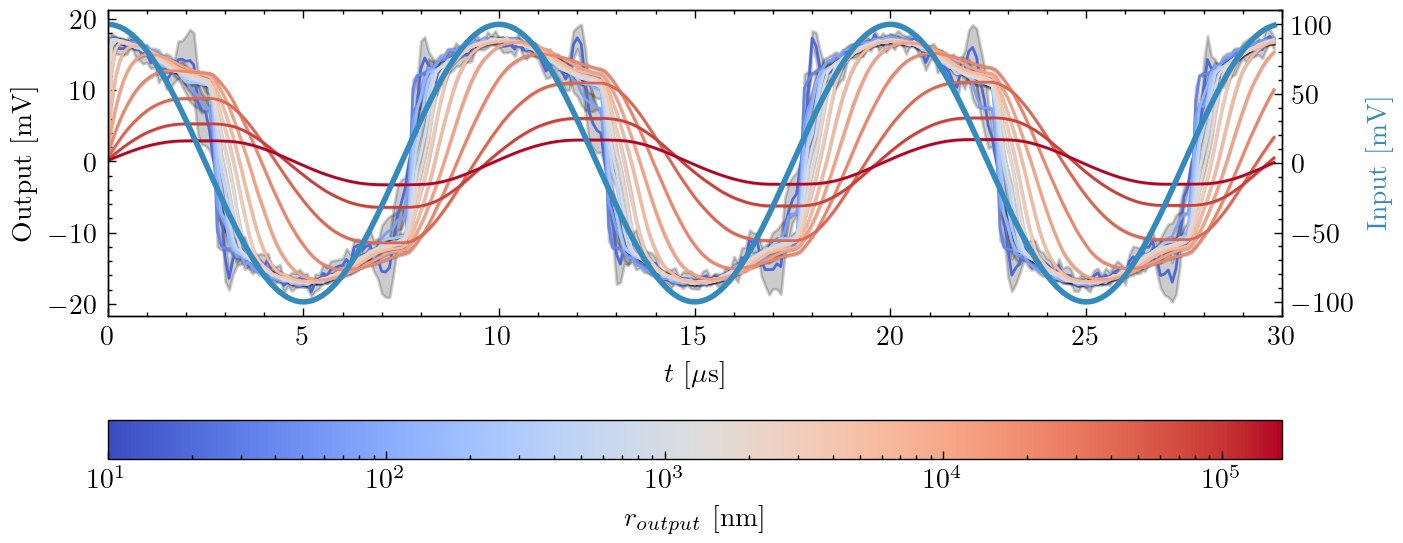

In [165]:
colormap    = 'coolwarm'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
# fig.set_figheight(fig.get_figheight()*1.5)
ax  = fig.add_subplot()
for i in range(len(radius_vals)):
    ax.plot(time_steps[:-1]*1e6, results[i][:,2]*1000, c=cmap((i+1)/len(radius_vals)))
    ax.fill_between(time_steps[:-1]*1e6, results[i][:,2]*1000-results[i][:,3]*1000,
                    results[i][:,2]*1000+results[i][:,3]*1000, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
ax.set_xlim(0,30)

ax2 = ax.twinx()
ax2.plot(time_steps[:-1]*1e6, voltages[:-1,0]*1000, nanonets_utils.blue_color, lw=2)
ax2.set_ylabel('Input [mV]', c=nanonets_utils.blue_color)
ax2.set_xlim(0,30)

norm    = mpl.colors.LogNorm(vmin=radius_vals[0], vmax=radius_vals[-1])
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, ax=ax, label='$r_{output}$ [nm]', orientation='horizontal', fraction=1, aspect=30)
fig.savefig('plots/magic_cable_sine_input.svg', bbox_inches='tight', transparent=True)

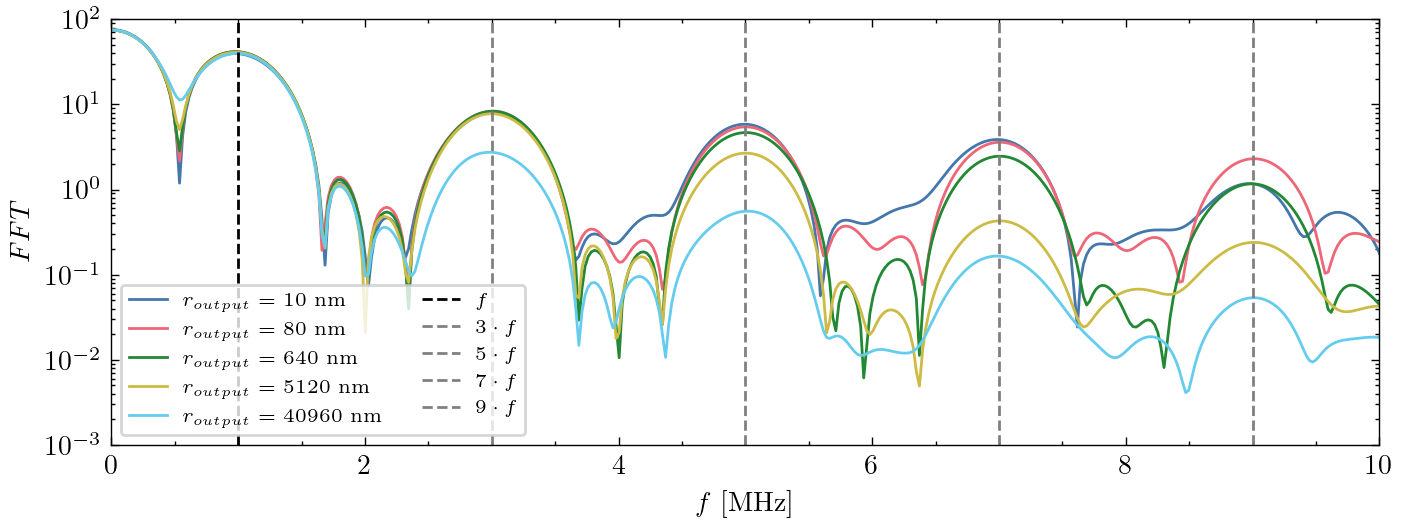

In [217]:
y_min   = 0.001
y_max   = 100

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()

for n in [0, 3, 6, 9, 12]:

    r_val   = radius_vals[n]
    signal  = results[n][:,2]
    signal  = (signal-np.min(signal))/(np.max(signal)-np.min(signal))
    xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=4096)

    ax.plot(xf*1e4/(2*np.pi) ,f ,label='$r_{output}'+f' = {r_val}$ nm')


ax.vlines(1, y_min, y_max, colors='black', ls='--', label='$f$')
ax.vlines(3, y_min, y_max, colors='grey', ls='--', label='$3 \cdot f$')
ax.vlines(5, y_min, y_max, colors='grey', ls='--', label='$5 \cdot f$')
ax.vlines(7, y_min, y_max, colors='grey', ls='--', label='$7 \cdot f$')
ax.vlines(9, y_min, y_max, colors='grey', ls='--', label='$9 \cdot f$')
ax.set_xlim(0,10)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.legend(ncol=2, frameon=True, fontsize='x-small')
ax.set_yscale("log")

fig.savefig('plots/magic_cable_sine_input_fft.svg', bbox_inches='tight', transparent=True)

## Step Input

In [202]:
# Voltage Paramter
N_voltages              = 300
time_step               = 1e-7
time_steps              = np.arange(N_voltages)*time_step
voltages                = np.zeros(shape=(N_voltages,9))
voltages[:,0]           = 0.05
voltages[20:60,0]       = 0.1

In [36]:
radius_vals     = [10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840]
results_step    = []
for radius in tqdm(radius_vals):
    val     = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results_step.append(val)

100%|██████████| 15/15 [02:25<00:00,  9.70s/it]


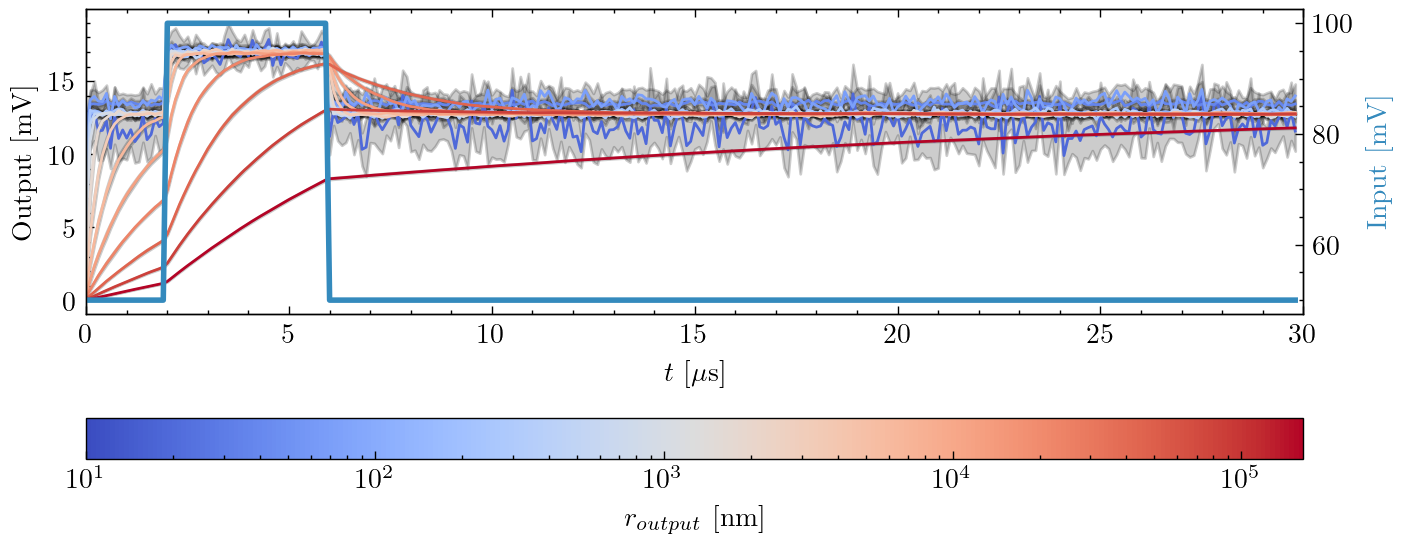

In [203]:
colormap    = 'coolwarm'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
# fig.set_figheight(fig.get_figheight()*1.5)
ax  = fig.add_subplot()
for i in range(len(radius_vals)):
    ax.plot(time_steps[:-1]*1e6, results_step[i][:,2]*1000, c=cmap((i+1)/len(radius_vals)))
    ax.fill_between(time_steps[:-1]*1e6, results_step[i][:,2]*1000-results_step[i][:,3]*1000,
                    results_step[i][:,2]*1000+results_step[i][:,3]*1000, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
ax.set_xlim(0,30)

ax2 = ax.twinx()
ax2.plot(time_steps[:-1]*1e6, voltages[:-1,0]*1000, nanonets_utils.blue_color, lw=2)
ax2.set_ylabel('Input [mV]', c=nanonets_utils.blue_color)
ax2.set_xlim(0,30)

norm    = mpl.colors.LogNorm(vmin=radius_vals[0], vmax=radius_vals[-1])
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, ax=ax, label='$r_{output}$ [nm]', orientation='horizontal', fraction=1, aspect=30)
fig.savefig('plots/magic_cable_step_input.svg', bbox_inches='tight', transparent=True)

## Frequency Double

In [204]:
# Voltage Paramter
N_voltages              = 300
amplitudes              = [0.1,0.0,0.0,0.05,0.0,0.0,0.0,0.0]
frequencies             = [1e5,0.0,0.0,3.5e5,0.0,0.0,0.0,0.0]
time_step               = 1e-7
time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                             amplitudes=amplitudes, frequencies=frequencies, time_step=time_step)

In [180]:
radius_vals     = [10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840]
results_2_sine  = []
for radius in tqdm(radius_vals):
    val     = run_magic_cable(time_steps, voltages, topology_parameter, radius, 0)
    results_2_sine.append(val)

100%|██████████| 15/15 [03:59<00:00, 15.99s/it]


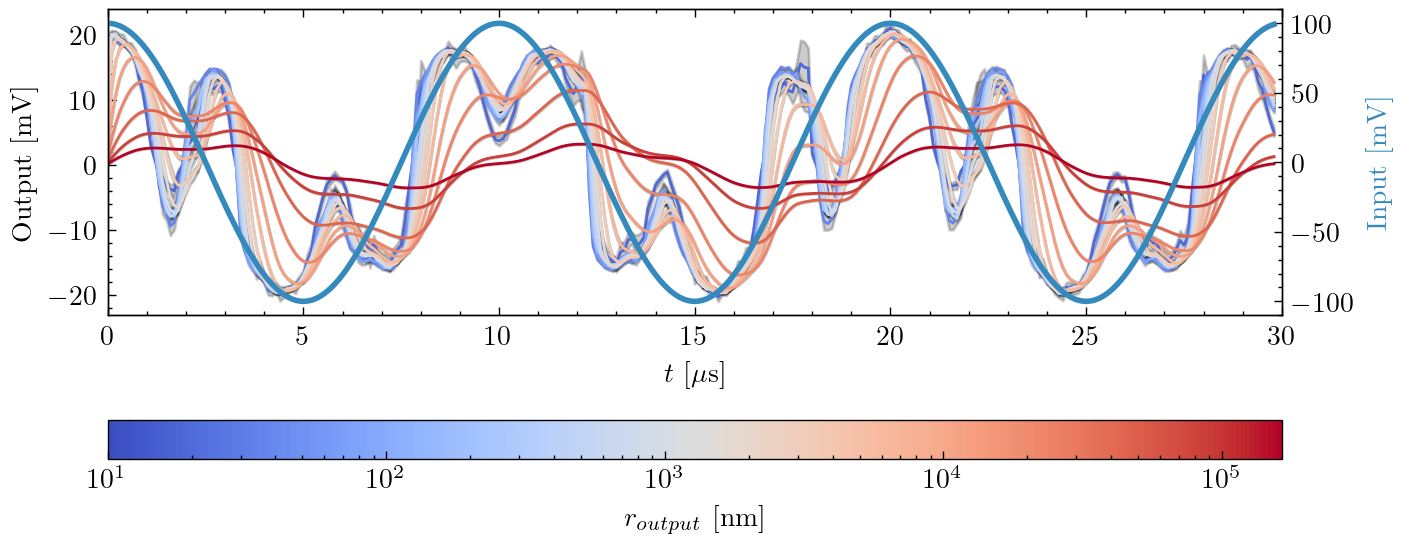

In [183]:
colormap    = 'coolwarm'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
# fig.set_figheight(fig.get_figheight()*1.5)
ax  = fig.add_subplot()
for i in range(len(radius_vals)):
    ax.plot(time_steps[:-1]*1e6, results_2_sine[i][:,2]*1000, c=cmap((i+1)/len(radius_vals)))
    ax.fill_between(time_steps[:-1]*1e6, results_2_sine[i][:,2]*1000-results_2_sine[i][:,3]*1000,
                    results_2_sine[i][:,2]*1000+results_2_sine[i][:,3]*1000, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
ax.set_xlim(0,30)

ax2 = ax.twinx()
ax2.plot(time_steps[:-1]*1e6, voltages[:-1,0]*1000, nanonets_utils.blue_color, lw=2)
ax2.set_ylabel('Input [mV]', c=nanonets_utils.blue_color)
ax2.set_xlim(0,30)

norm    = mpl.colors.LogNorm(vmin=radius_vals[0], vmax=radius_vals[-1])
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, ax=ax, label='$r_{output}$ [nm]', orientation='horizontal', fraction=1, aspect=30)
fig.savefig('plots/magic_cable_two_sine_input.svg', bbox_inches='tight', transparent=True)

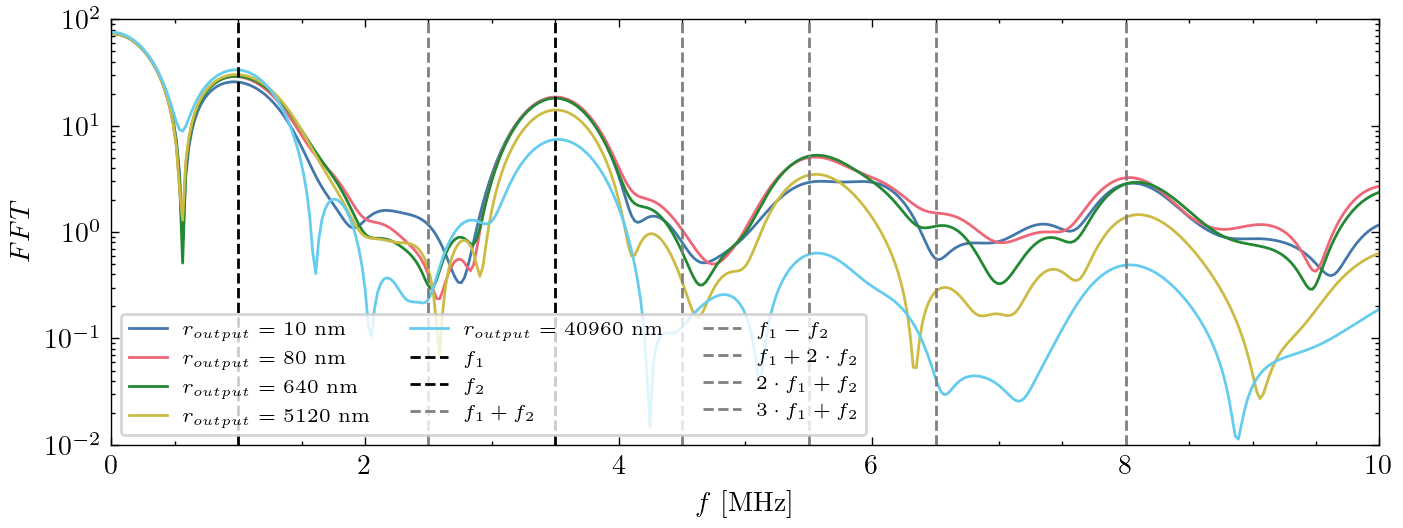

In [214]:
y_min   = 0.01
y_max   = 100
f1      = 1
f2      = 3.5

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()

for n in [0, 3, 6, 9, 12]:

    r_val   = radius_vals[n]
    signal  = results_2_sine[n][:,2]
    signal  = (signal-np.min(signal))/(np.max(signal)-np.min(signal))
    xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=4096)

    ax.plot(xf*1e4/(2*np.pi) ,f ,label='$r_{output}'+f' = {r_val}$ nm')

ax.vlines(f1, y_min, y_max, colors='black', ls='--', label='$f_1$')
ax.vlines(f2, y_min, y_max, colors='black', ls='--', label='$f_2$')
ax.vlines(f1+f2, y_min, y_max, colors='grey', ls='--', label='$f_1+f_2$')
ax.vlines(f2-f1, y_min, y_max, colors='grey', ls='--', label='$f_1-f_2$')
ax.vlines(f1+2*f2, y_min, y_max, colors='grey', ls='--', label='$f_1+2 \cdot f_2$')
ax.vlines(2*f1+f2, y_min, y_max, colors='grey', ls='--', label='$2 \cdot f_1+f_2$')
ax.vlines(3*f1+f2, y_min, y_max, colors='grey', ls='--', label='$3 \cdot f_1+f_2$')

ax.set_xlim(0,10)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.legend(ncol=3, frameon=True, fontsize='x-small', loc='lower left')
ax.set_yscale('log')
fig.savefig('plots/magic_cable_two_sine_input_fft.svg', bbox_inches='tight', transparent=True)